## **Смотрим на аудиосэмпл**

In [4]:
x , sr = librosa.load('recordings/russian1.mp3', sr=None)
x.shape

(1430457,)

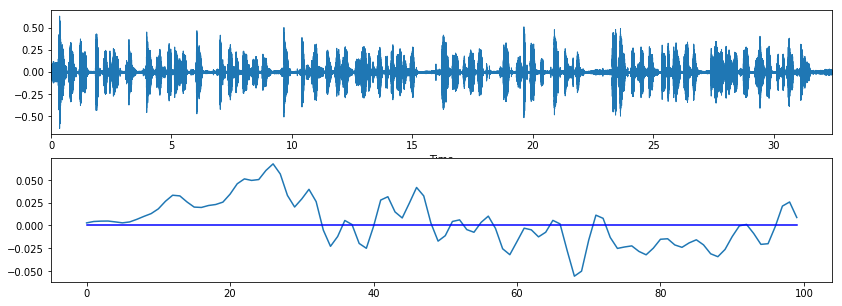

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
plt.subplot(211)
librosa.display.waveplot(x, sr=sr)
plt.subplot(212)
plt.plot(x[0:100])
plt.plot([0 for _ in range(100)], color='b')

## **Загружаем данные из таблицы, считаем zero-crossing, формируем датафрейм для обработки моделью**

In [0]:
import pandas as pd
dataset = pd.read_csv('speakers_all.csv').iloc[:, 0:9]
dataset = dataset[dataset['file_missing?'] == False]

## **Отбираем языки, представлненные достаточным количеством семплов**

In [7]:
languages = dataset['native_language'].value_counts()[dataset['native_language'].value_counts().values > 30].index
languages

Index(['english', 'spanish', 'arabic', 'mandarin', 'french', 'korean',
       'russian', 'portuguese', 'dutch', 'turkish', 'german', 'polish',
       'italian'],
      dtype='object')

In [8]:
ds = []
for lang in languages:
   ds.append(dataset[dataset['native_language'] == lang])
ds = pd.concat(ds, axis=0)
ds.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False


## **Считаем zero-crossings**

In [9]:
import glob
filenames = glob.glob('recordings/*')
print([fn.split('/')[1] for fn in filenames])

['english46.mp3', 'english412.mp3', 'tagalog12.mp3', 'portuguese9.mp3', 'english420.mp3', 'tigrigna8.mp3', 'tagalog2.mp3', 'russian16.mp3', 'wolof1.mp3', 'vietnamese11.mp3', 'german9.mp3', 'nepali12.mp3', 'english88.mp3', 'hindi14.mp3', 'italian2.mp3', 'english309.mp3', 'finnish8.mp3', 'spanish145.mp3', 'dutch11.mp3', 'somali3.mp3', 'english153.mp3', 'english324.mp3', 'turkish14.mp3', 'farsi10.mp3', 'bulgarian18.mp3', 'dari2.mp3', 'hebrew9.mp3', 'polish15.mp3', 'swedish9.mp3', 'english103.mp3', 'spanish86.mp3', 'ewe2.mp3', 'english385.mp3', 'bulgarian12.mp3', 'bengali8.mp3', 'french26.mp3', 'arabic89.mp3', 'taiwanese6.mp3', 'english482.mp3', 'urdu6.mp3', 'spanish104.mp3', 'english2.mp3', 'english514.mp3', 'papiamentu1.mp3', 'macedonian6.mp3', 'french48.mp3', 'english448.mp3', 'turkish23.mp3', 'english143.mp3', 'english399.mp3', 'russian4.mp3', 'spanish155.mp3', 'english214.mp3', 'yiddish3.mp3', 'estonian2.mp3', 'italian9.mp3', 'english534.mp3', 'english147.mp3', 'amharic19.mp3', 'engli

In [10]:
crossings = dict()
from tqdm import tqdm

for fn in tqdm(filenames):
  x, _ = librosa.load(fn, sr=None)
  crossings[fn.split('/')[1]] =  librosa.zero_crossings(x, pad=False)
  

100%|██████████| 2138/2138 [11:47<00:00,  2.17it/s]


In [0]:
cross = dict()
for k, v in crossings.items():
  cross[k.split('.')[0]] = v.sum()

In [0]:
pd_cross = pd.DataFrame.from_dict(cross, orient='index')

In [0]:
pd_cross.to_csv('cross.csv', header=None, sep='\t')

In [0]:
ds = ds.join(pd_cross, on='filename')
ds = ds.drop('file_missing?', axis=1)
df = ds[['age', 'native_language', 'sex', 0]]
df.columns = ['age', 'native_language', 'sex', 'zero_cross']

In [15]:
df.head()

,age,native_language,sex,zero_cross
363,42.0,english,male,81246
364,35.0,english,female,57371
365,23.0,english,female,77926
366,18.0,english,female,85929
367,22.0,english,male,95090


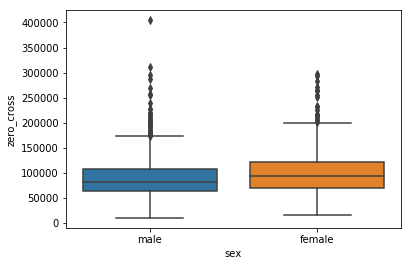

In [17]:
import seaborn as sns
sns.boxplot(data=df[['sex', 'zero_cross']], x='sex', y='zero_cross' )

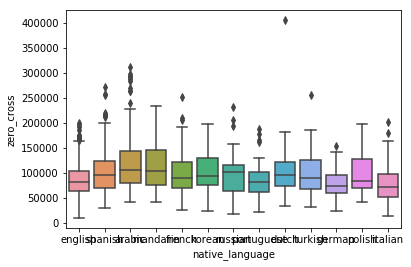

In [18]:
sns.boxplot(x='native_language', y='zero_cross', data=df)

## **Проверяем гипотезу отсутствия влияния социальных признаков на zero_crossing  и  влияния межфакторноого взаимодействия между признаками на zero_crossing**

In [0]:
from statsmodels.formula.api import ols

In [0]:
lm_all = ols('zero_cross ~ C(sex) * age * C(native_language)', data=df).fit()
lm_ind = ols('zero_cross ~ C(sex) + age + C(native_language)', data=df).fit()

In [21]:
import statsmodels.api as sm
lm_ind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     11.28
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           8.20e-25
Time:                        18:41:36   Log-Likelihood:                -15719.
No. Observations:                1306   AIC:                         3.147e+04
Df Residuals:                    1291   BIC:                         3.155e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         1.228e+05   4952.723     24.795      0.000    1.13e+05    1.33e+05
C(sex)[T.male]                   -9684.0598   2299.489     -4.211      0.000   -1.42e+04   -5172.916
C(native_language)[T.dutch]      -2.188e+04   7252.562     -3.017      0.003   -3.61e+04   -7654.942
C(native_language)[T.english]    -4.169e+04   4418.158     -9.435      0.000   -5.04e+04    -3.3e+04
C(native_language)[T.french]      -2.66e+04   6583.234     -4.041      0.000   -3.95e+04   -1.37e+04
C(native_language)[T.german]     -4.629e+04   7971.744     -5.806      0.000   -6.19e+04   -3.06e+04
C(native_language)[T.italian]     -4.14e+04   8235.526     -5.027      0.000   -5.76e+04   -2.52e+04
C(native_language)[T.korean]     -2.386e+04   7003.118     -3.408      0.001   -3.76e+04   -1.01e+04
C(native_language)[T.mandarin]   -1.338e+04   6530.624     -2.048      0.041   -2.62e+04    -565.430
C(native_language)[T.polish]     -2.912e+04   8131.527     -3.581      0.000   -4.51e+04   -1.32e+04
C(native_language)[T.portuguese]  -3.79e+04   7186.813     -5.274      0.000    -5.2e+04   -2.38e+04
C(native_language)[T.russian]    -3.077e+04   7197.590     -4.275      0.000   -4.49e+04   -1.67e+04
C(native_language)[T.spanish]    -2.148e+04   5194.923     -4.135      0.000   -3.17e+04   -1.13e+04
C(native_language)[T.turkish]    -2.403e+04   7891.892     -3.044      0.002   -3.95e+04   -8544.439
age                                271.0643     77.430      3.501      0.000     119.161     422.967
==============================================================================
Omnibus:                      370.250   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1286.902
Skew:                           1.362   Prob(JB):                    3.57e-280
Kurtosis:                       7.028   Cond. No.                         502.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
sm.stats.anova_lm(lm_ind, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,19.580953,1.045503e-05
C(native_language),12.0,2.125880e+11,1.771567e+10,10.511379,4.259323e-20
age,1.0,2.065479e+10,2.065479e+10,12.255270,4.797568e-04
Residual,1291.0,2.175826e+12,1.685380e+09,NaN,NaN


## **Заметим, zero_crossing зависит от каждого из признаков. Проверим зависимость от межфакторного взаимодействия этих признаков.**

In [23]:
lm_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     4.587
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           1.24e-22
Time:                        18:41:48   Log-Likelihood:                -15682.
No. Observations:                1306   AIC:                         3.147e+04
Df Residuals:                    1254   BIC:                         3.174e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            1.121e+05   1.89e+04      5.924      0.000     7.5e+04    1.49e+05
C(sex)[T.male]                                      -5.496e+04   2.35e+04     -2.340      0.019   -1.01e+05   -8887.040
C(native_language)[T.dutch]                          1.866e+04   2.75e+04      0.678      0.498   -3.53e+04    7.26e+04
C(native_language)[T.english]                       -2.599e+04   1.97e+04     -1.319      0.188   -6.47e+04    1.27e+04
C(native_language)[T.french]                        -1.022e+04   2.46e+04     -0.416      0.678   -5.85e+04     3.8e+04
C(native_language)[T.german]                         -5.57e+04   2.73e+04     -2.044      0.041   -1.09e+05   -2234.784
C(native_language)[T.italian]                       -8.912e+04    3.8e+04     -2.348      0.019   -1.64e+05   -1.47e+04
C(native_language)[T.korean]                        -3.543e+04   2.73e+04     -1.300      0.194   -8.89e+04     1.8e+04
C(native_language)[T.mandarin]                       3.571e+04   3.25e+04      1.099      0.272    -2.8e+04    9.95e+04
C(native_language)[T.polish]                        -8170.6463   3.55e+04     -0.230      0.818   -7.79e+04    6.16e+04
C(native_language)[T.portuguese]                    -1.595e+04   3.55e+04     -0.449      0.653   -8.56e+04    5.37e+04
C(native_language)[T.russian]                       -6.244e+04   2.79e+04     -2.236      0.026   -1.17e+05   -7662.171
C(native_language)[T.spanish]                        -1.01e+04   2.29e+04     -0.441      0.659    -5.5e+04    3.48e+04
C(native_language)[T.turkish]                       -5.864e+04   5.52e+04     -1.061      0.289   -1.67e+05    4.97e+04
C(sex)[T.male]:C(native_language)[T.dutch]            9.49e+04   4.01e+04      2.367      0.018    1.63e+04    1.74e+05
C(sex)[T.male]:C(native_language)[T.english]         4.918e+04   2.47e+04      1.989      0.047     666.363    9.77e+04
C(sex)[T.male]:C(native_language)[T.french]          2.367e+04   3.36e+04      0.703      0.482   -4.23e+04    8.97e+04
C(sex)[T.male]:C(native_language)[T.german]           4.55e+04   5.24e+04      0.868      0.385   -5.73e+04    1.48e+05
C(sex)[T.male]:C(native_language)[T.italian]         1.333e+05   4.76e+04      2.802      0.005       4e+04    2.27e+05
C(sex)[T.male]:C(native_language)[T.korean]          7585.4018   4.13e+04      0.184      0.854   -7.34e+04    8.86e+04
C(sex)[T.male]:C(native_language)[T.mandarin]       -2.068e+04   4.57e+04     -0.452      0.651    -1.1e+05     6.9e+04
C(sex)[T.male]:C(native_language)[T.polish]          3.969e+04   4.19e+04      0.948      0.343   -4.25e+04    1.22e+05
C(sex)[T.male]:C(native_language)[T.portuguese]      5.019e+04    4.4e+04      1.14

## **Т.к. R-squared и Log-Likelihood увеличились, качество нашей модели выросло. Посмотрим, можно ли бурать из модели влияние некоторых межвакторных взаимодействий.**

In [24]:
sm.stats.anova_lm(lm_all, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,20.107546,7.990675e-06
C(native_language),12.0,2.125880e+11,1.771567e+10,10.794062,1.100565e-20
C(sex):C(native_language),12.0,2.082059e+10,1.735049e+09,1.057156,3.932967e-01
age,1.0,2.046657e+10,2.046657e+10,12.470172,4.284991e-04
C(sex):age,1.0,2.159247e+08,2.159247e+08,0.131562,7.168793e-01
age:C(native_language),12.0,7.581416e+10,6.317846e+09,3.849430,8.315852e-06
C(sex):age:C(native_language),12.0,2.104581e+10,1.753818e+09,1.068592,3.830928e-01
Residual,1254.0,2.058118e+12,1.641242e+09,NaN,NaN


## **Видно, что в модели можно учитывать межфакторное взаимодействие только возраста и родного языка **

In [37]:
lm = ols('zero_cross ~ C(sex) + age + C(native_language) + age:C(native_language)', data=df).fit()
sm.stats.anova_lm(lm, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,20.055030,8.195736e-06
C(native_language),12.0,2.125880e+11,1.771567e+10,10.765871,1.208135e-20
age,1.0,2.065479e+10,2.065479e+10,12.551984,4.100321e-04
age:C(native_language),12.0,7.118047e+10,5.931706e+09,3.604717,2.531060e-05
Residual,1279.0,2.104645e+12,1.645540e+09,NaN,NaN


In [38]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     7.887
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           3.04e-27
Time:                        18:56:31   Log-Likelihood:                -15697.
No. Observations:                1306   AIC:                         3.145e+04
Df Residuals:                    1279   BIC:                         3.159e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             8.455e+04   1.12e+04      7.567      0.000    6.26e+04    1.06e+05
C(sex)[T.male]                       -9777.1643   2284.134     -4.280      0.000   -1.43e+04   -5296.104
C(native_language)[T.dutch]           6.306e+04   1.92e+04      3.283      0.001    2.54e+04    1.01e+05
C(native_language)[T.english]         3622.1126   1.18e+04      0.308      0.758   -1.95e+04    2.67e+04
C(native_language)[T.french]          7176.8017   1.62e+04      0.444      0.657   -2.46e+04    3.89e+04
C(native_language)[T.german]         -1.702e+04   2.04e+04     -0.833      0.405   -5.71e+04    2.31e+04
C(native_language)[T.italian]        -6329.4709   2.25e+04     -0.282      0.778   -5.04e+04    3.78e+04
C(native_language)[T.korean]         -1.965e+04   1.94e+04     -1.014      0.311   -5.77e+04    1.84e+04
C(native_language)[T.mandarin]        2.875e+04   2.22e+04      1.293      0.196   -1.49e+04    7.24e+04
C(native_language)[T.polish]            1.6e+04   1.86e+04      0.859      0.391   -2.06e+04    5.26e+04
C(native_language)[T.portuguese]      1.488e+04   2.09e+04      0.711      0.477   -2.62e+04    5.59e+04
C(native_language)[T.russian]        -2.887e+04   1.81e+04     -1.596      0.111   -6.44e+04    6614.754
C(native_language)[T.spanish]          1.19e+04    1.4e+04      0.851      0.395   -1.55e+04    3.93e+04
C(native_language)[T.turkish]         6117.1397   3.16e+04      0.194      0.846   -5.58e+04    6.81e+04
age                                   1508.8700    335.148      4.502      0.000     851.369    2166.371
age:C(native_language)[T.dutch]      -2859.4241    604.897     -4.727      0.000   -4046.123   -1672.726
age:C(native_language)[T.english]    -1440.8832    350.092     -4.116      0.000   -2127.700    -754.066
age:C(native_language)[T.french]     -1101.9874    461.573     -2.387      0.017   -2007.511    -196.464
age:C(native_language)[T.german]      -949.0281    605.558     -1.567      0.117   -2137.025     238.969
age:C(native_language)[T.italian]    -1147.3893    606.457     -1.892      0.059   -2337.150      42.371
age:C(native_language)[T.korean]      -212.0408    558.473     -0.380      0.704   -1307.664     883.583
age:C(native_language)[T.mandarin]   -1365.4698    704.664     -1.938      0.053   -2747.893      16.954
age:C(native_language)[T.polish]     -1466.6019    556.910     -2.633      0.009   -2559.160    -374.044
age:C(native_language)[T.portuguese] -1726.2092    656.370     -2.630      0.009   -3013.890    -438.529
age:C(native_language)[T.russian]     -171.8558    507.338     -0.339      0.735   -1167.161     823.450
age:C(native_language)[T.spanish]    -1093.4689    406.652     -2.689      0.007   -1891.247    -295.691
age:C(native_language)[T.turkish]     

## **Действительно, есть зависимость от совместного влияния возраста и родного языка. При этом после удаления остальных межфакторных взаимодействий качество модели ухудшилось.**

## **Посмотрим на распределение среднего числа zero-crossing по возрастам. Разобьём возраст на три категориальных признака, чтобы внутри каждой группы дисперсия была примерно постоянной**

Text(0, 0.5, 'zero_cross_sum')

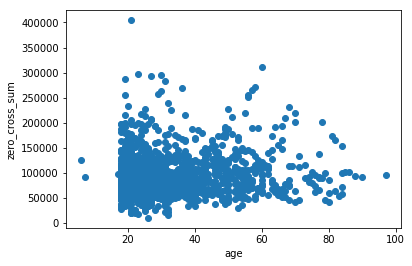

In [26]:
import numpy as np
plt.scatter(df.age.values, df.zero_cross.values)
plt.xlabel('age')
plt.ylabel('zero_cross_sum')

In [0]:
new_data = []

new_data.append(df[['zero_cross', 'sex', 'native_language']][df.age <= 40])
new_data[-1]['age'] = 'young'

new_data.append(df[['zero_cross', 'sex', 'native_language']][np.logical_and(df.age > 40, df.age <= 60)])
new_data[-1]['age'] = 'adult'

new_data.append(df[['zero_cross', 'sex', 'native_language']][df.age > 60])
new_data[-1]['age'] = 'old'

new_data = pd.concat(new_data, axis=0)

In [29]:
new_data.head()

,zero_cross,sex,native_language,age
364,57371,female,english,young
365,77926,female,english,young
366,85929,female,english,young
367,95090,male,english,young
368,37848,male,english,young


## **Проведем аналогичный анализ в данном случае.**

In [31]:
lm_simple = ols('zero_cross ~ C(sex) + C(native_language) + C(age)',data=new_data).fit()
table = sm.stats.anova_lm(lm_simple)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,19.632115,1.018351e-05
C(native_language),12.0,2.125880e+11,1.771567e+10,10.538843,3.715323e-20
C(age),2.0,2.800610e+10,1.400305e+10,8.330248,2.543209e-04
Residual,1290.0,2.168475e+12,1.680988e+09,NaN,NaN


In [32]:
lm_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     10.85
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           3.79e-25
Time:                        18:46:46   Log-Likelihood:                -15717.
No. Observations:                1306   AIC:                         3.147e+04
Df Residuals:                    1290   BIC:                         3.155e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         1.394e+05   4885.243     28.528      0.000     1.3e+05    1.49e+05
C(sex)[T.male]                   -9756.6092   2295.120     -4.251      0.000   -1.43e+04   -5254.033
C(native_language)[T.dutch]      -2.195e+04   7244.733     -3.030      0.002   -3.62e+04   -7738.349
C(native_language)[T.english]    -4.173e+04   4417.047     -9.447      0.000   -5.04e+04   -3.31e+04
C(native_language)[T.french]     -2.648e+04   6587.707     -4.020      0.000   -3.94e+04   -1.36e+04
C(native_language)[T.german]     -4.641e+04   7961.380     -5.829      0.000    -6.2e+04   -3.08e+04
C(native_language)[T.italian]    -4.167e+04   8227.156     -5.064      0.000   -5.78e+04   -2.55e+04
C(native_language)[T.korean]      -2.41e+04   6996.255     -3.445      0.001   -3.78e+04   -1.04e+04
C(native_language)[T.mandarin]   -1.291e+04   6524.451     -1.979      0.048   -2.57e+04    -109.602
C(native_language)[T.polish]     -2.916e+04   8121.193     -3.591      0.000   -4.51e+04   -1.32e+04
C(native_language)[T.portuguese] -3.743e+04   7180.779     -5.213      0.000   -5.15e+04   -2.33e+04
C(native_language)[T.russian]    -3.012e+04   7198.059     -4.184      0.000   -4.42e+04    -1.6e+04
C(native_language)[T.spanish]    -2.167e+04   5188.695     -4.176      0.000   -3.18e+04   -1.15e+04
C(native_language)[T.turkish]    -2.373e+04   7883.987     -3.010      0.003   -3.92e+04   -8266.716
C(age)[T.old]                     2111.0715   5351.977      0.394      0.693   -8388.461    1.26e+04
C(age)[T.young]                  -1.029e+04   2953.821     -3.484      0.001   -1.61e+04   -4495.756
==============================================================================
Omnibus:                      373.072   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1310.954
Skew:                           1.369   Prob(JB):                    2.14e-285
Kurtosis:                       7.074   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **Заметим, что качество модели немного улчшилось для случая категориального разделения возраста**

In [33]:
lm = ols('zero_cross ~ C(sex) * C(native_language) * C(age)',data=new_data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,20.128960,7.911423e-06
C(native_language),12.0,2.125880e+11,1.771567e+10,10.805558,1.070591e-20
C(age),2.0,2.800610e+10,1.400305e+10,8.541068,2.070137e-04
C(sex):C(native_language),12.0,2.089015e+10,1.740845e+09,1.061817,3.891317e-01
C(sex):C(age),2.0,9.577993e+08,4.788996e+08,0.292102,7.467440e-01
C(native_language):C(age),24.0,1.059210e+11,4.413376e+09,2.691910,1.992276e-05
C(sex):C(native_language):C(age),24.0,1.132035e+10,4.716811e+08,0.287699,9.997300e-01
Residual,1239.0,2.031336e+12,1.639496e+09,NaN,NaN


In [34]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.796
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           1.25e-20
Time:                        18:49:05   Log-Likelihood:                -15674.
No. Observations:                1306   AIC:                         3.148e+04
Df Residuals:                    1239   BIC:                         3.183e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        1.418e+05   1.53e+04      9.268      0.000    1.12e+05    1.72e+05
C(sex)[T.male]                                                  -6359.9048   1.93e+04     -0.330      0.741   -4.41e+04    3.14e+04
C(native_language)[T.dutch]                                     -6.919e+04   3.25e+04     -2.131      0.033   -1.33e+05   -5497.057
C(native_language)[T.english]                                    -4.61e+04   1.63e+04     -2.834      0.005    -7.8e+04   -1.42e+04
C(native_language)[T.french]                                    -1.297e+04   2.54e+04     -0.511      0.609   -6.28e+04    3.68e+04
C(native_language)[T.german]                                     -6.88e+04   2.37e+04     -2.902      0.004   -1.15e+05   -2.23e+04
C(native_language)[T.italian]                                   -7.637e+04   3.25e+04     -2.352      0.019    -1.4e+05   -1.27e+04
C(native_language)[T.korean]                                    -4805.3214    2.1e+04     -0.229      0.819   -4.59e+04    3.63e+04
C(native_language)[T.mandarin]                                  -1.482e+04   2.25e+04     -0.658      0.511    -5.9e+04    2.94e+04
C(native_language)[T.polish]                                    -3.161e+04   2.54e+04     -1.246      0.213   -8.14e+04    1.82e+04
C(native_language)[T.portuguese]                                -7.423e+04   2.79e+04     -2.657      0.008   -1.29e+05   -1.94e+04
C(native_language)[T.russian]                                   -2.969e+04   2.54e+04     -1.170      0.242   -7.95e+04    2.01e+04
C(native_language)[T.spanish]                                   -1.372e+04   1.77e+04     -0.777      0.438   -4.84e+04    2.09e+04
C(native_language)[T.turkish]                                   -1.002e+04   2.22e+04     -0.452      0.651   -5.35e+04    3.35e+04
C(age)[T.old]                                                    3.718e+04   1.73e+04      2.145      0.032    3179.913    7.12e+04
C(age)[T.young]                                                 -4820.5429   1.68e+04     -0.288      0.774   -3.77e+04    2.81e+04
C(sex)[T.male]:C(native_language)[T.dutch]                      -3492.2619   4.17e+04     -0.084      0.933   -8.53e+04    7.83e+04
C(sex)[T.male]:C(native_language)[T.english]                    -8307.2004   2.07e+04     -0.402      0.688   -4.89e+04    3.23e+04
C(sex)[T.male]:C(native_language)[T.french]                     -1.026e+04   3.45e+04     -0.297      0.766    -7.8e+04    5.74e+04
C(sex)[T.male]:C(native_language)[T.german]                      5.881e+04    3.9e+04      1.509      0.132   -1.76e+04    1.35e+05
C(sex)[T.male]:C(native_language)[T.italian]   

## **Как и в предыдущем случае оставляем межфакторное взаимодействие только возраста и родного языка.**

In [35]:
lm = ols('zero_cross ~ C(sex) + C(native_language) + C(age) + C(native_language):C(age)',data=new_data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,3.300135e+10,3.300135e+10,20.224712,7.515947e-06
C(native_language),12.0,2.125880e+11,1.771567e+10,10.856959,7.802866e-21
C(age),2.0,2.800610e+10,1.400305e+10,8.581697,1.986162e-04
C(native_language):C(age),24.0,9.977824e+10,4.157427e+09,2.547858,5.917319e-05
Residual,1268.0,2.069039e+12,1.631734e+09,NaN,NaN


In [36]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             zero_cross   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     6.179
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           1.32e-26
Time:                        18:51:44   Log-Likelihood:                -15686.
No. Observations:                1306   AIC:                         3.145e+04
Df Residuals:                    1268   BIC:                         3.164e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                         1.441e+05   9378.426     15.367      0.000    1.26e+05    1.63e+05
C(sex)[T.male]                                   -9959.2654   2280.299     -4.368      0.000   -1.44e+04   -5485.691
C(native_language)[T.dutch]                       -7.14e+04   2.03e+04     -3.517      0.000   -1.11e+05   -3.16e+04
C(native_language)[T.english]                    -5.089e+04   9999.822     -5.089      0.000   -7.05e+04   -3.13e+04
C(native_language)[T.french]                     -1.858e+04    1.7e+04     -1.091      0.275    -5.2e+04    1.48e+04
C(native_language)[T.german]                     -5.325e+04   1.79e+04     -2.978      0.003   -8.83e+04   -1.82e+04
C(native_language)[T.italian]                    -5.419e+04   1.53e+04     -3.539      0.000   -8.42e+04   -2.41e+04
C(native_language)[T.korean]                     -3493.0238   1.42e+04     -0.245      0.806   -3.14e+04    2.44e+04
C(native_language)[T.mandarin]                   -1.427e+04   1.64e+04     -0.873      0.383   -4.64e+04    1.78e+04
C(native_language)[T.polish]                     -3.822e+04   2.03e+04     -1.880      0.060   -7.81e+04    1655.095
C(native_language)[T.portuguese]                 -6.877e+04   2.03e+04     -3.386      0.001   -1.09e+05   -2.89e+04
C(native_language)[T.russian]                    -3.692e+04   2.03e+04     -1.816      0.070   -7.68e+04    2959.695
C(native_language)[T.spanish]                    -1.675e+04   1.12e+04     -1.499      0.134   -3.87e+04    5168.811
C(native_language)[T.turkish]                     1.469e+04   4.15e+04      0.354      0.723   -6.66e+04     9.6e+04
C(age)[T.old]                                     7.579e+04      3e+04      2.523      0.012    1.69e+04    1.35e+05
C(age)[T.young]                                  -1.794e+04   1.03e+04     -1.742      0.082   -3.81e+04    2262.449
C(native_language)[T.dutch]:C(age)[T.old]        -6.456e+04   4.52e+04     -1.428      0.154   -1.53e+05    2.42e+04
C(native_language)[T.english]:C(age)[T.old]      -7.336e+04   3.08e+04     -2.381      0.017   -1.34e+05   -1.29e+04
C(native_language)[T.french]:C(age)[T.old]       -8.296e+04   3.66e+04     -2.266      0.024   -1.55e+05   -1.11e+04
C(native_language)[T.german]:C(age)[T.old]       -2.959e+04   5.26e+04     -0.562      0.574   -1.33e+05    7.36e+04
C(native_language)[T.italian]:C(age)[T.old]       3.652e+04   5.19e+04      0.704      0.481   -6.52e+04    1.38e+05
C(native_language)[T.korean]:C(age)[T.old]        -1.09e+05   5.15e+04     -2.115      0.035    -2.1e+05   -7911.952
C(native_language)[T.mandarin]:C(age)[T.old]     -8.217e-11   5.93e-11     -1.385      0.166   -1.99e-10    3.42e-11
C(native_language)[T.polish]:C(age)[T.old

## **Качество модели в данном случае лучше, чем при возрасте - числовом признаке. При этом ее качество близко к качеству лучшей модели для числового возраста.**

#### Так же мы проверяли качество выборки: нормальность распределения внутри групп, одинаковость значений дисперсия признака во всех группах. Но не удалось разделить возраст на категории так, чтобы выполнялись необходимые условия.